In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet

In [73]:
from pandas.tseries.holiday import Holiday, AbstractHolidayCalendar

def get_paques(dt):
    y = dt.year
    c = int(y / 100)
    n = (y % 19)
    k = int((c - 17) / 25)
    b = int(c / 4)
    e = int((c - k) / 3)
    f = c - b - e + (19 * n) + 15
    h = (f % 30)
    p = int(h / 28)
    q = int(29 / (h + 1))
    r = int((21 - n) / 11)
    i = h - (p * (1 - (p * q * r)))
    s = int(y / 4)
    t = int(c / 4)
    u = y + s + i + 2 - c + t
    j = (u % 7)
    w = int((i - j + 40) / 44)
    m = 3 + w
    x = int(m / 4)
    d = i - j + 28 - (31 * x)
    return pd.datetime(y, m, d)


def get_lundi_paques(dt):
    return get_paques(dt) + pd.Timedelta(days=1)


def get_ascension(dt):
    return get_paques(dt) + pd.Timedelta(days=39)


def get_lundi_pentecote(dt):
    return get_paques(dt) + pd.Timedelta(days=50)


def get_vendredi_saint(dt):
    return get_paques(dt) - pd.Timedelta(days=2)


class CalendarFR(AbstractHolidayCalendar):
    rules = [Holiday('Nouvel an', month=1, day=1),
             Holiday('Fete du travail', month=5, day=1),
             Holiday('Victoire 1945', month=5, day=8),
             Holiday('Fete Nationale', month=7, day=14),
             Holiday('Assomption', month=8, day=15),
             Holiday('La Toussaint', month=11, day=1),
             Holiday('Noel', month=12, day=25),
             Holiday('Lundi de Paques', month=1, day=1, observance=get_lundi_paques),
             Holiday('Ascension', month=1, day=1, observance=get_ascension),
             Holiday('Lundi de Pentecote', month=1, day=1, observance=get_lundi_pentecote)]


In [74]:
df = pd.read_csv('../../Desktop/data.csv', skiprows=3, header=None, names=['y', 'ds'])
df['ds'] = pd.to_datetime(df['ds'].values, utc=True).tz_convert('Europe/Paris').tz_localize(None)
df = df.set_index('ds').resample('1D').sum().reset_index()
df['y'] /= 144
df.head()

,ds,y
0,2014-12-30,1375.326389
1,2014-12-31,1028.534722
2,2015-01-01,638.944444
3,2015-01-02,1203.958333
4,2015-01-03,615.965278


In [62]:
holidays_df = (
    CalendarFR()
    .holidays(start=df['ds'].min(), end=df['ds'].max(), return_name=True)
    .to_frame('holiday')
    .reset_index()
    .rename(columns={'index': 'ds'})
)
holidays_df['lower_window'] = 0
holidays_df['upper_window'] = 0

In [63]:
m = Prophet(growth='linear', 
            changepoints=None, 
            n_changepoints=25, 
            yearly_seasonality=True, 
            weekly_seasonality=True, 
            holidays=holidays_df,  # to add holidays effect
            seasonality_prior_scale=10.0,
            holidays_prior_scale=10.0, 
            changepoint_prior_scale=0.05,
            mcmc_samples=500,  # to add intervals in season and week
            interval_width=0.8, 
            uncertainty_samples=1000)
m.fit(df);

In [64]:
future = m.make_future_dataframe(freq='1D', periods=365)
future.tail()

,ds
1156,2018-03-02
1157,2018-03-03
1158,2018-03-04
1159,2018-03-05
1160,2018-03-06


In [65]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1156,2018-03-02,1451.935941,998.635150,1895.862182
1157,2018-03-03,550.842694,97.497806,1015.478046
1158,2018-03-04,305.401809,-123.331134,757.413782
1159,2018-03-05,1458.522577,1000.515129,1892.326062
1160,2018-03-06,1620.839063,1171.142315,2089.343347


<IPython.core.display.Javascript object>


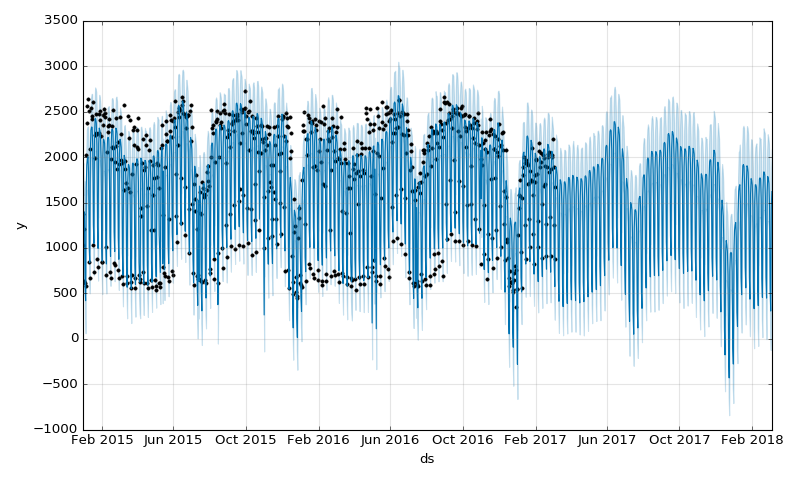

In [66]:
%matplotlib notebook
#%matplotlib inline
m.plot(forecast);

<IPython.core.display.Javascript object>


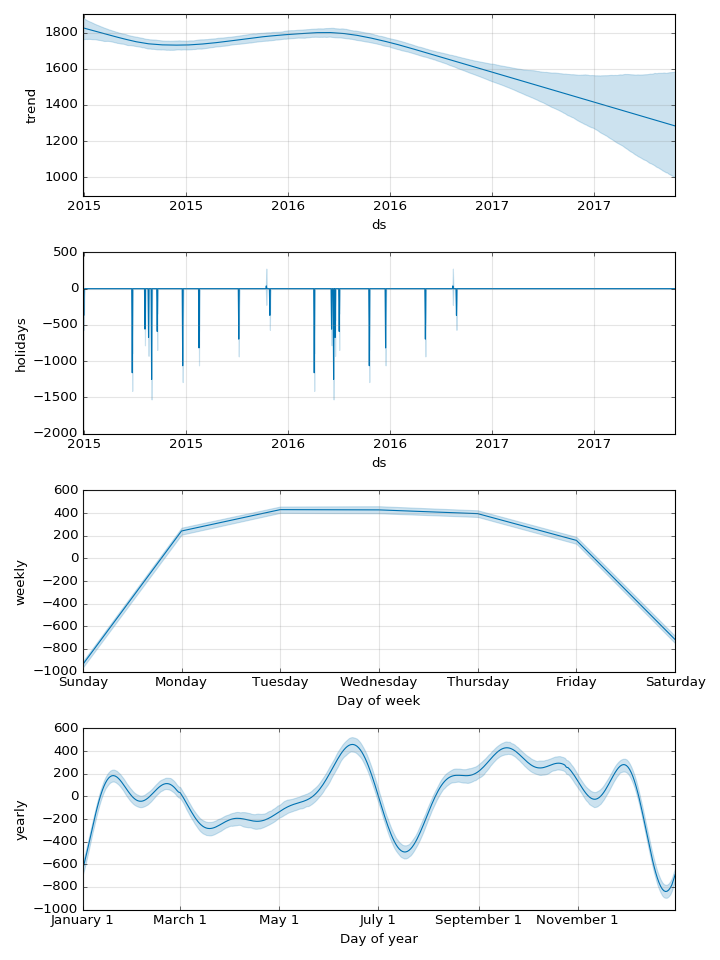

In [67]:
m.plot_components(forecast);

In [260]:
test = pd.concat([df.set_index('ds'), forecast.set_index('ds')], axis=1)
#test = test[~test['y'].isnull()]
print('RMSE', np.sqrt(((test['y'] - test['yhat'])**2).mean()))
print('MeanAE', ((test['y'] - test['yhat']).abs()).mean())
print('MedianAE', ((test['y'] - test['yhat']).abs()).median())
print('MAPE', ((test['y'] - test['yhat']).abs()/ test['y']).mean() * 100)

RMSE 288.454262875
MeanAE 211.23434575
MedianAE 156.95192208979466
MAPE 17.4305918095


In [69]:
test = pd.concat([df.set_index('ds'), forecast.set_index('ds')], axis=1)
#test = test[~test['y'].isnull()]
print('RMSE', np.sqrt(((test['y'] - test['yhat'])**2).mean()))
print('MeanAE', ((test['y'] - test['yhat']).abs()).mean())
print('MedianAE', ((test['y'] - test['yhat']).abs()).median())
print('MAPE', ((test['y'] - test['yhat']).abs()/ test['y']).mean() * 100)
print('CVRMSE',  np.sqrt(((test['y'] - test['yhat'])**2).mean())/np.nanmean(test['y']) * 100)

RMSE 261.527588172
MeanAE 198.904517886
MedianAE 156.51313357672836
MAPE 16.2108562562
CVRMSE 15.1676127609


In [70]:
out = forecast.set_index('ds').drop('t', axis=1)

In [72]:
out.to_csv('../../Desktop/forecast.csv')